### 使用 MMSegmentation 算法库，撰写 config 配置文件，训练 PSPNet 语义分割算法

In [4]:
import os
os.chdir('/home/dongkaixing/openMMlabCamp/MMSegmentation_Tutorials/20230612/mmsegmentation')


# !unzip /home/dongkaixing/openMMlabCamp/Watermelon87_Semantic_Seg_Mask.zip -d .

Archive:  /home/dongkaixing/openMMlabCamp/Watermelon87_Semantic_Seg_Mask.zip
replace ./Watermelon87_Semantic_Seg_Mask/img_dir/train/IMG_6865-1024x683.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [ ]:
# mmsegmentation/mmseg/datasets/WatermelonDataset.py
from mmseg.registry import DATASETS
from .basesegdataset import BaseSegDataset

@DATASETS.register_module()
class WatermelonDataset(BaseSegDataset):
    # 类别和对应的可视化配色
    METAINFO = {
        # 按照灰度排序 0 1 2 3 4 5
        'classes':['Unlabeled', 'red', 'green', 'white', 'seed-black', 'seed-white'],
        'palette':[[132,41,246], [228,193,110], [152,16,60], [58,221,254], [41,169,226], [155,155,155]]
    }
    
    # 指定图像扩展名、标注扩展名
    def __init__(self,
                 img_suffix='.jpg',
                 seg_map_suffix='.png',
                 reduce_zero_label=False, # 类别ID为0的类别是否需要除去
                 **kwargs) -> None:
        super().__init__(
            img_suffix=img_suffix,
            seg_map_suffix=seg_map_suffix,
            reduce_zero_label=reduce_zero_label,
            **kwargs)

In [ ]:
# mmsegmentation/configs/_base_/datasets/WatermelonDataset_pipeline.py

# dataset settings
dataset_type = 'WatermelonDataset' # 数据集类名
data_root = 'Watermelon87_Semantic_Seg_Mask/' # 数据集路径（相对于mmsegmentation主目录）
crop_size = (64, 64)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(
        type='RandomResize',
        scale=(2048, 1024),
        ratio_range=(0.5, 2.0),
        keep_ratio=True),
    dict(type='RandomCrop', crop_size=crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='PackSegInputs')
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(2048, 1024), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]
img_ratios = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75]
tta_pipeline = [
    dict(type='LoadImageFromFile', file_client_args=dict(backend='disk')),
    dict(
        type='TestTimeAug',
        transforms=[
            [
                dict(type='Resize', scale_factor=r, keep_ratio=True)
                for r in img_ratios
            ],
            [
                dict(type='RandomFlip', prob=0., direction='horizontal'),
                dict(type='RandomFlip', prob=1., direction='horizontal')
            ], [dict(type='LoadAnnotations')], [dict(type='PackSegInputs')]
        ])
]
train_dataloader = dict(
    batch_size=2,
    num_workers=2,
    persistent_workers=True,
    sampler=dict(type='InfiniteSampler', shuffle=True),
    dataset=dict(
        type=dataset_type,
        data_root=data_root,
        data_prefix=dict(
            img_path='img_dir/train', seg_map_path='ann_dir/train'),
        pipeline=train_pipeline))
val_dataloader = dict(
    batch_size=1,
    num_workers=4,
    persistent_workers=True,
    sampler=dict(type='DefaultSampler', shuffle=False),
    dataset=dict(
        type=dataset_type,
        data_root=data_root,
        data_prefix=dict(
            img_path='img_dir/val', seg_map_path='ann_dir/val'),
        pipeline=test_pipeline))
test_dataloader = val_dataloader

val_evaluator = dict(type='IoUMetric', iou_metrics=['mIoU'])
test_evaluator = val_evaluator




In [ ]:
# mmsegmentation/configs/pspnet/pspnet_r50-d8_4xb2-40k_WatermelonDataset.py

_base_ = [
    '../_base_/models/pspnet_r50-d8.py', '../_base_/datasets/WatermelonDataset_pipeline.py',
    '../_base_/default_runtime.py', '../_base_/schedules/schedule_40k.py'
]
crop_size = (64, 64) # 输入图像尺寸，根据自己数据集情况修改
data_preprocessor = dict(size=crop_size)
model = dict(data_preprocessor=data_preprocessor)

In [3]:
from mmengine import Config
cfg = Config.fromfile('./configs/pspnet/pspnet_r50-d8_4xb2-40k_WatermelonDataset.py')

FileNotFoundError: file "/home/dongkaixing/openMMlabCamp/homework/homework4/configs/pspnet/pspnet_r50-d8_4xb2-40k_WatermelonDataset.py" does not exist

In [ ]:
print(cfg.pretty_text)

norm_cfg = dict(type='SyncBN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(64, 64))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(64, 64)),
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        chann

##### 可进行任何调参

In [ ]:
# configs/_base_/models/pspnet_r50-d8.py
cfg.norm_cfg = dict(type='BN', requires_grad=True) # 只使用GPU时，BN取代SyncBN
cfg.crop_size = (256, 256)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head

# 模型 decode/auxiliary 输出头，指定为类别个数
cfg.model.decode_head.num_classes = 6
cfg.model.auxiliary_head.num_classes = 6

# _base_/datasets/DubaiDataset_pipeline.py
cfg.train_dataloader.batch_size = 8

cfg.test_dataloader = cfg.val_dataloader




## configs/_base_/schedules/schedule_40k.py

# 训练迭代次数
cfg.train_cfg.max_iters = 3000
# 评估模型间隔
cfg.train_cfg.val_interval = 400
# 日志记录间隔
cfg.default_hooks.logger.interval = 100
# 模型权重保存间隔
cfg.default_hooks.checkpoint.interval = 1500


# 额外配置
# 随机数种子
cfg['randomness'] = dict(seed=0)
# 结果保存目录
cfg.work_dir = './work_dirs/WatermelonDataset'

In [ ]:
print(cfg.pretty_text)

norm_cfg = dict(type='BN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(64, 64))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(256, 256)),
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=51

In [ ]:
cfg.dump('pspnet-WatermelonDataset_20230614.py')

In [ ]:
!python tools/train.py pspnet-WatermelonDataset_20230614.py

FileNotFoundError: [Errno 2] No such file or directory: 'Watermelon87_Semantic_Seg_Mask/ann_dir/train/21746.1.png'

FileNotFoundError: [Errno 2] No such file or directory: 'Watermelon87_Semantic_Seg_Mask/ann_dir/val/01bd15599c606aa801201794e1fa30.png@1280w_1l_2o_100sh.png'


更改数据集相应图片名称


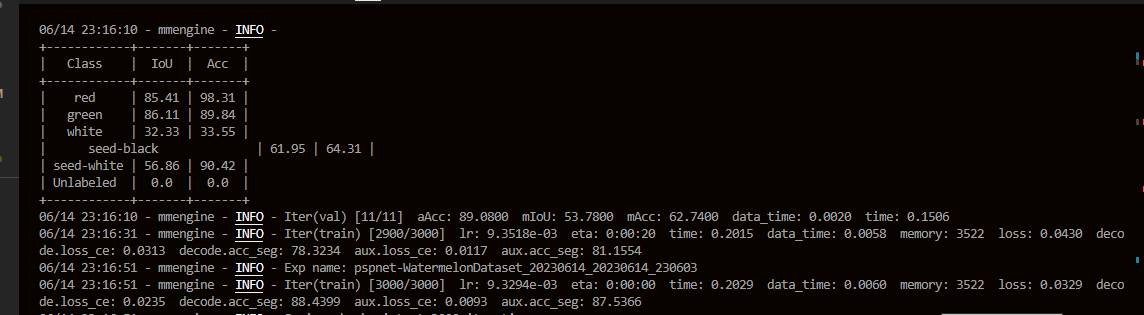

### 提交测试集评估指标

In [ ]:
!python tools/test.py pspnet-WatermelonDataset_20230614.py work_dirs/WatermelonDataset/iter_3000.pth

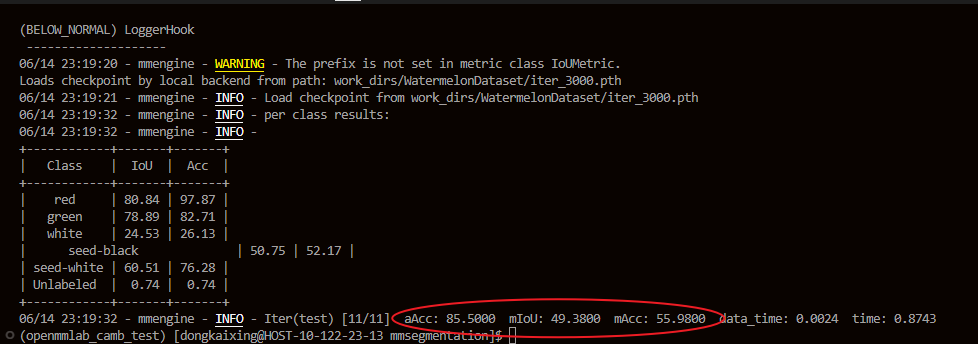

### 预测

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from mmseg.apis import init_model, inference_model, show_result_pyplot
import mmcv
import cv2

In [2]:
# 载入 config 配置文件
from mmengine import Config
cfg = Config.fromfile('pspnet-WatermelonDataset_20230614.py')

FileNotFoundError: file "/home/dongkaixing/openMMlabCamp/homework/homework4/pspnet-WatermelonDataset_20230614.py" does not exist

In [ ]:
from mmengine.runner import Runner
from mmseg.utils import register_all_modules

# register all modules in mmseg into the registries
# do not init the default scope here because it will be init in the runner

register_all_modules(init_default_scope=False)
runner = Runner.from_cfg(cfg)

06/14 23:50:16 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.16 (default, Mar  2 2023, 03:21:46) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0,1,2,3,4,5,6,7: Tesla V100-SXM2-32GB
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.2, V11.2.152
    GCC: gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-44)
    PyTorch: 1.10.1+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=comput

/home/dongkaixing/anaconda3/envs/openmmlab_camb_test/lib/python3.8/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmseg.visualization.local_visualizer.SegLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(
/home/dongkaixing/openMMlabCamp/MMSegmentation_Tutorials/20230612/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/home/dongkaixing/openMMlabCamp/MMSegmentation_Tutorials/20230612/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/dongkaixing/openMMlabCamp/MMSegmentation_Tutorials/20230612/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:2

06/14 23:50:18 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
06/14 23:50:18 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/home/dongkaixing/openMMlabCamp/MMSegmentation_Tutorials/20230612/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [ ]:
checkpoint_path = './work_dirs/WatermelonDataset/iter_3000.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

Loads checkpoint by local backend from path: ./work_dirs/WatermelonDataset/iter_3000.pth


In [ ]:
img = mmcv.imread('Watermelon87_Semantic_Seg_Mask/img_dir/val/R.jpeg')

In [ ]:
result = inference_model(model, img)

In [ ]:
result.keys()

['pred_sem_seg', 'seg_logits']

In [ ]:
pred_mask = result.pred_sem_seg.data[0].cpu().numpy()

In [ ]:
pred_mask.shape

(1333, 2000)

In [ ]:
np.unique(pred_mask)

array([0, 1, 2, 3, 4])

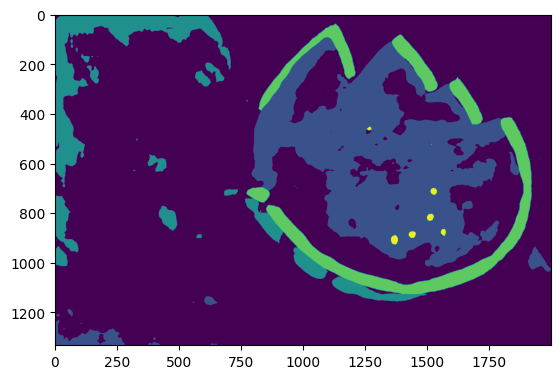

In [ ]:
plt.imshow(pred_mask)
plt.show()

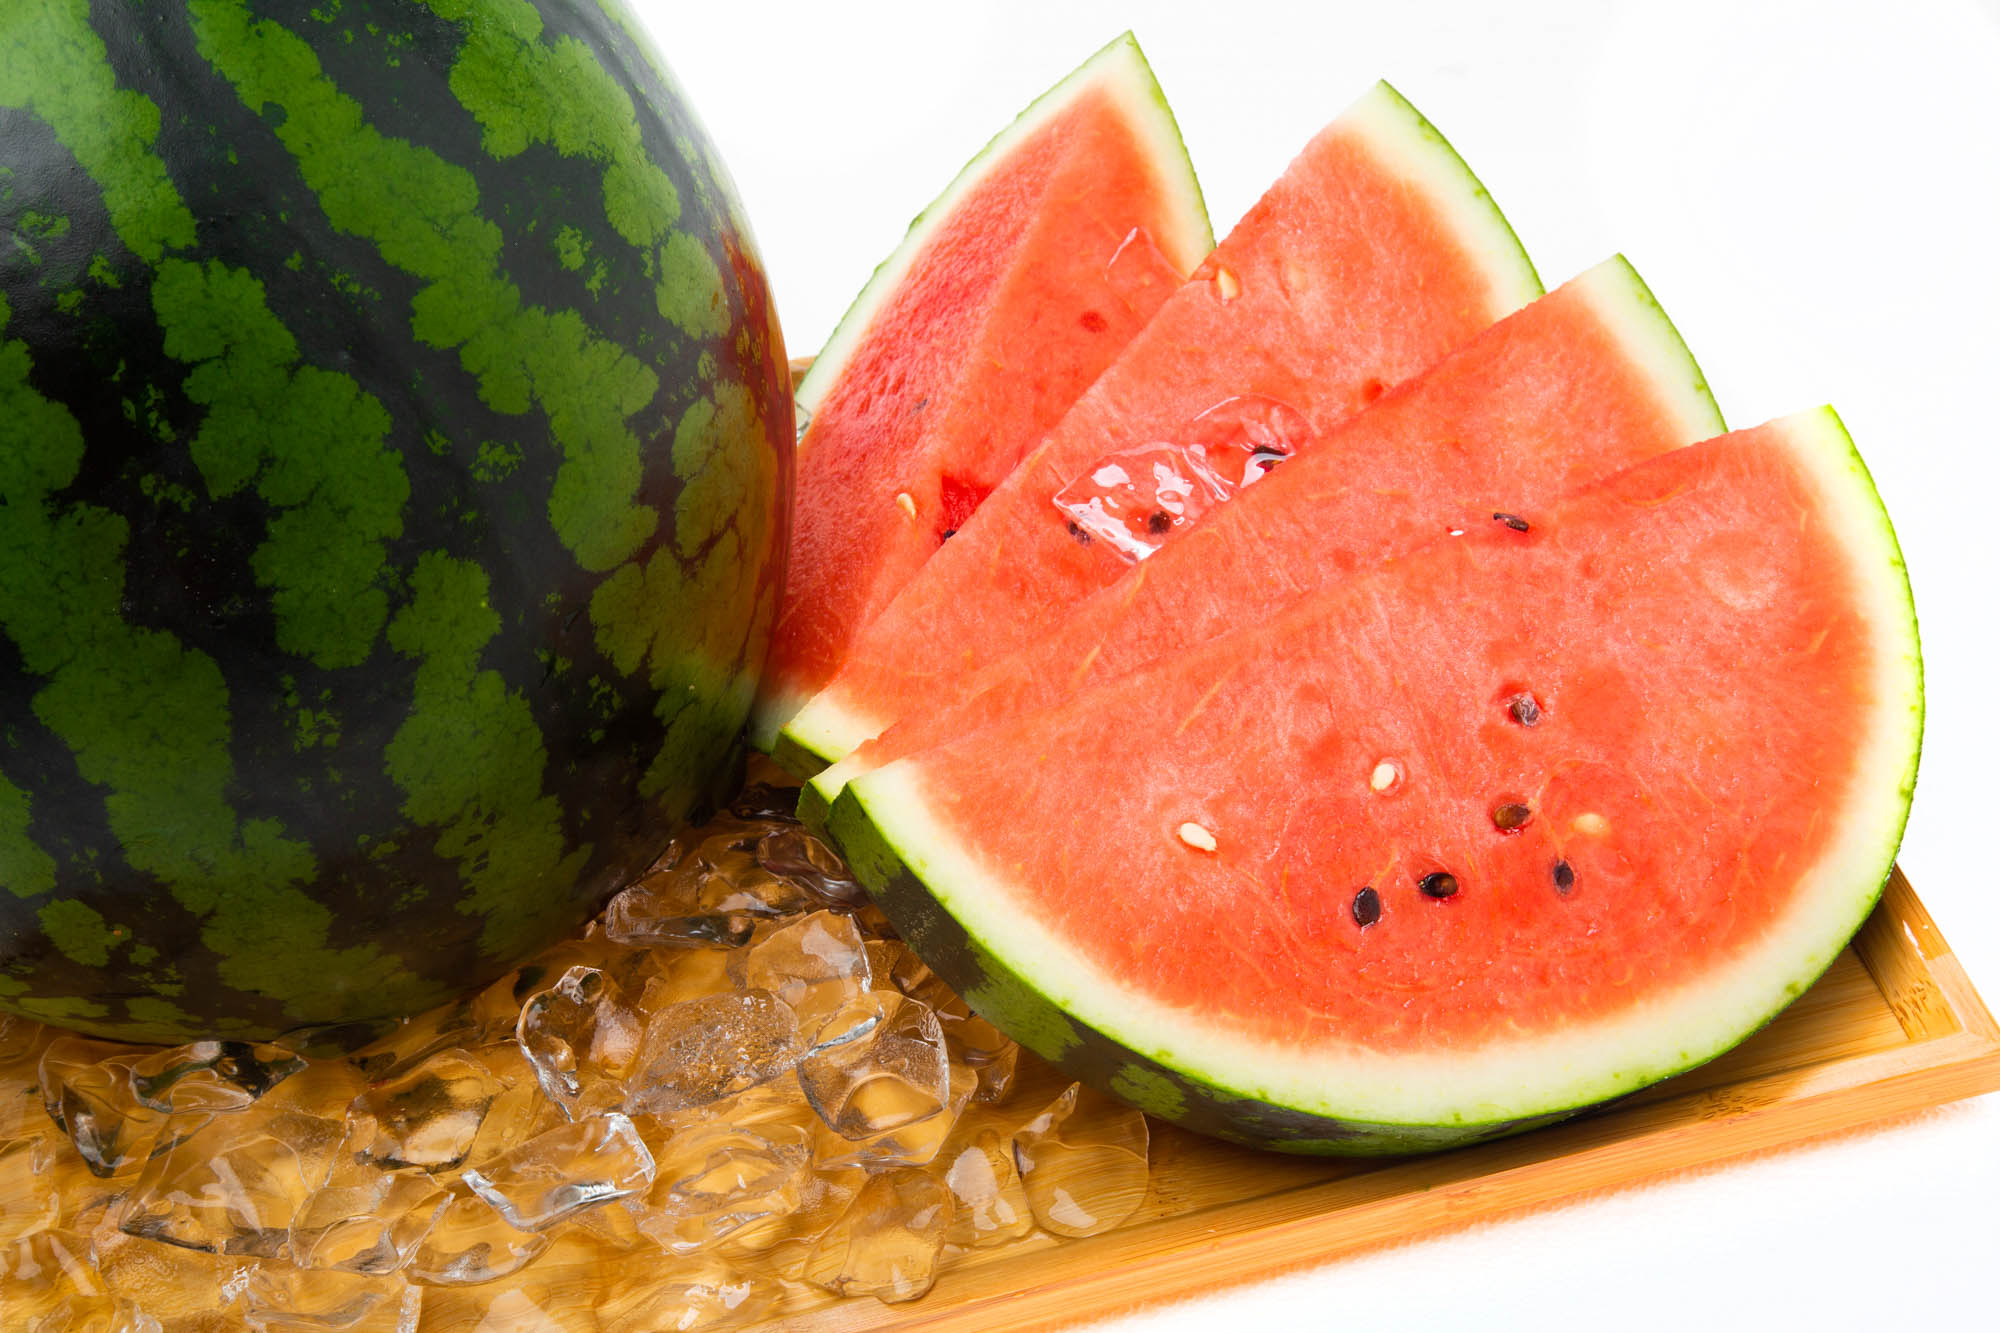

In [ ]:
# img_origin = cv2.imread('Watermelon87_Semantic_Seg_Mask/img_dir/val/R.jpeg')
# plt.imshow(img_origin)
# plt.show()
from PIL import Image
Image.open('Watermelon87_Semantic_Seg_Mask/img_dir/val/R.jpeg')

06/14 23:52:31 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


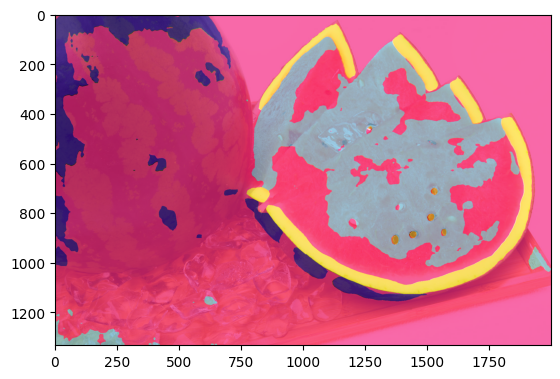

In [ ]:
# 可视化预测结果
visualization = show_result_pyplot(model, img, result, opacity=0.7, out_file='outputs/pred.jpg')
plt.imshow(mmcv.bgr2rgb(visualization))
plt.show()

In [ ]:
label = mmcv.imread('Watermelon87_Semantic_Seg_Mask/ann_dir/val/R.png')

In [ ]:
label.shape

(1333, 2000, 3)

In [ ]:
label_mask = label[:,:,0]

In [ ]:
np.unique(label_mask)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

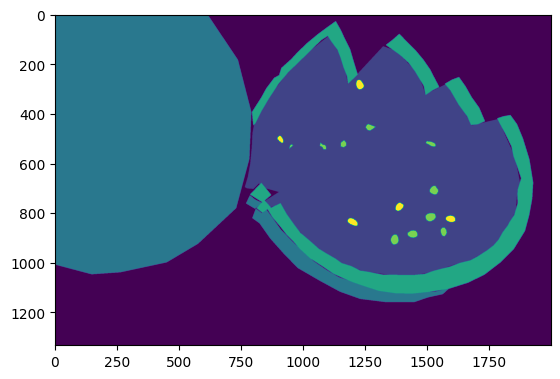

In [ ]:
plt.imshow(label_mask)
plt.show()

['red', 'green', 'white', 'seed-black\t', 'seed-white', 'Unlabeled']


/home/dongkaixing/anaconda3/envs/openmmlab_camb_test/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


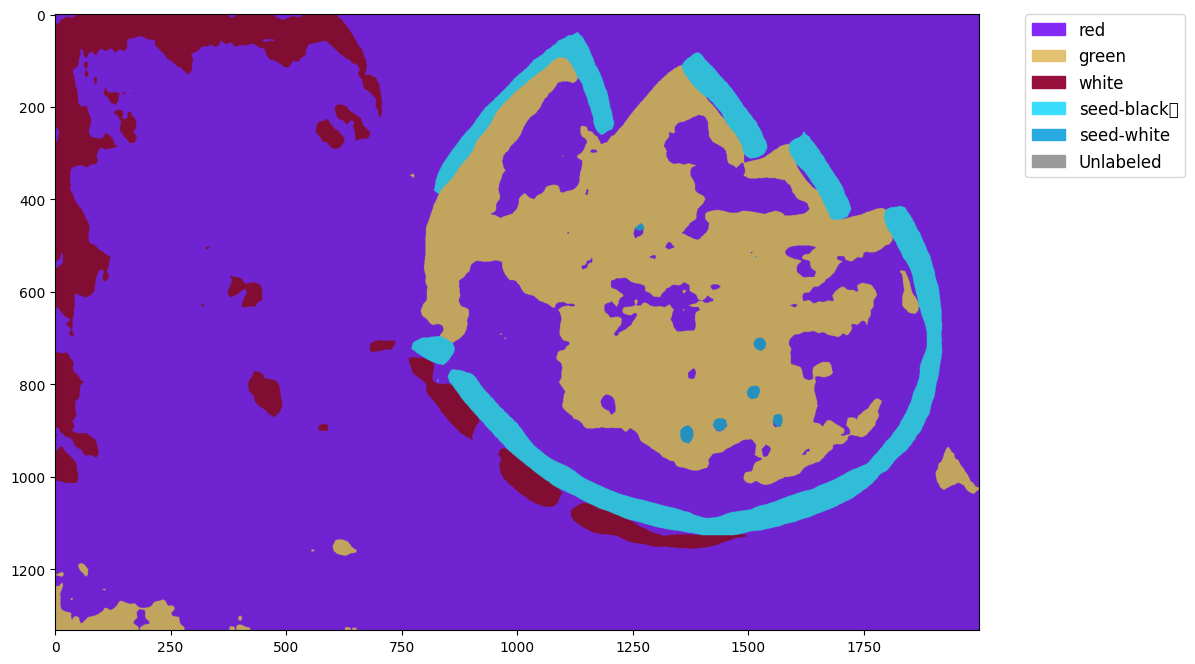

In [ ]:
from mmseg.datasets import WatermelonDataset
import numpy as np
import mmcv 

img_path='Watermelon87_Semantic_Seg_Mask/ann_dir/val/R.png'

# 获取类别名和调色板
classes = WatermelonDataset.METAINFO['classes']
print(classes)
palette = WatermelonDataset.METAINFO['palette']
opacity = 0.15 # 透明度，越大越接近原图

# 将分割图按调色板染色
# seg_map = result[0].astype('uint8')
seg_map = pred_mask.astype('uint8')
seg_img = Image.fromarray(seg_map).convert('P')
seg_img.putpalette(np.array(palette, dtype=np.uint8))

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
plt.figure(figsize=(14, 8))
im = plt.imshow(((np.array(seg_img.convert('RGB')))*(1-opacity) + mmcv.imread(img_path)*opacity) / 255)

# 为每一种颜色创建一个图例
patches = [mpatches.Patch(color=np.array(palette[i])/255., label=classes[i]) for i in range(6)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='large')

plt.show()